<a href="https://colab.research.google.com/github/MatteoOnger/BSP_Project/blob/main/BSP_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BSP Project: ECG signal decomposition using Fourier analysis**

*   **Author:** Matteo Onger
*   **Date:** February 2025

**Documentation**:
*   Paper: [ECG signal decomposition using Fourier analysis](https://doi.org/10.1186/s13634-024-01171-x)
*   Dataset: [Lobachevsky University Electrocardiography Database](https://www.physionet.org/content/ludb/1.0.1/)
*   Python packages: [WFDB](https://pypi.org/project/wfdb/)

**Notes**:
*   For faster execution, please use a gpu-equipped runtime.

In [1]:
# install library
!pip install wfdb

# download repository
!git clone -b main https://github.com/MatteoOnger/BSP_Project.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 92.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
Cloning into 'BSP_Project'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 6), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 685.42 KiB | 3.07 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
# ---- LIBRARIES ----
import importlib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from typing import Literal

from BSP_Project.rbfuncs import GaussianRBF, RadialBasisFunc
from BSP_Project.signals import ECG


# set logger
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(name)s:%(funcName)s - %(message)s", level=logging.INFO, force=True)
logger = logging.getLogger(__name__)


# current runtime type, if gpu available use cupy else numpy
if os.environ["COLAB_GPU"] != "":
    GPU = True
    logger.info("GPU connected")
    logger.info("Load Cupy")
    ncp = importlib.import_module("cupy")
else:
    GPU = False
    logger.info("No accelerator connected")
    ncp = np

2025-01-30 20:03:48,352 | INFO | __main__:<cell line: 0> - No accelerator connected


In [14]:
# ---- FUNCTIONS ----
def dft_l1(x :ncp.ndarray, K :int, max_iters :int=5, eps :float|None=1e-6, fast_init :bool=True) -> ncp.ndarray:
    """
    Computes the l1 Fourier transform of a real signal ``x`` and returns the Fourier coefficients.
    The parameter ``K`` determines the number of Fourier coefficients to compute, so,
    if it is not equal to the length of ``x``, a truncated l1 Fourier trasform is computed.

    Parameters
    ----------
    x : numpy.ndarray | cupy.ndarray of shape \(N)
        Original signal, i.e. an array of ``N`` real numbers that are the samples collected.
    K : int
        Number of Fourier coefficients to compute.
    max_iters : int, optional
        Maximum number of iterations, by default is ``5``.
    eps : float | None, optional
        Tolerance for the convergence of the algorithm, by default is ``1e-6``.
        If ``None``, the algorithm will run until the maximum number of iterations is reached.
    fast_init : bool, optional
        If ``True``, the algorithm will use a faster initialization of the Fourier coefficients, by default is ``True``.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(K)
        The Fourier coefficients computed, i.e. an array of ``K`` complex numbers.

    Raises
    ------
    : ValueError
        If ``K != N`` and ``K > 1 + N//2``.

    Notes
    -----
    - If the input signal ``x`` contains complex numbers, only the real part is taken into account.
    """
    N = len(x)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("<K> must be equal to the length of <x> or smaller/equal than half the length of <x> plus 1")

    logger.info(f"Start -> K={K}, max_iters={max_iters}, eps={eps}")

    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # keep only real part
    x = ncp.real(x)

    # total number of coefficients computed
    # including complex conjugates
    M = 2*K - 1 if K != N else K
    if (N % 2 == 0) and (K == 1 + N//2):
        M -= 1

    # fourier basis, matrix of shape (N,M) and its conjugate transpose
    fi = ncp.exp(ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K-M, K, 1)] for n in range(N)])) / ncp.sqrt(N)
    tconj_fi = ncp.transpose(ncp.conj(fi))

    # init fourier coefficients
    coeff = ncp.zeros(fi.shape[1], dtype=ncp.complex128)
    # reconstructed signal
    xk = x + 1 if fast_init else ncp.real(fi @ coeff)
    # previously recon. signal
    prev_xk = None

    for iter in range(max_iters):
        delta = ncp.abs(x - xk)
        delta = ncp.diag(1 / ncp.where(delta == 0, 1e-18, delta))

        # update fourier coefficients and prev. recon. signal and recon. signal
        coeff = ncp.linalg.inv(tconj_fi @ delta @ fi) @ tconj_fi @ delta @ x
        prev_xk = xk
        xk = ncp.real(fi @ coeff)

        # check convergency
        conv = np.mean(np.abs(xk - prev_xk))
        logger.debug(f"Iteration {iter+1} -> convergency={conv}")
        if (eps is not None) and (conv <= eps):
            break

    # compute final convergency and loss wrt original signal
    conv, loss = np.mean(np.abs(xk - prev_xk)), ncp.abs((x - xk) / np.where(x == 0, 1, x))
    logger.info(f"End -> iter={iter+1}, " +
        f"convergency={ncp.round(conv, 4)}, " +
        f"min_abs_loss={ncp.around(ncp.min(loss), 4)}, "  +
        f"avg_abs_loss={ncp.around(ncp.mean(loss), 4)}, " +
        f"max_abs_loss={ncp.around(ncp.max(loss), 4)}"
    )
    return ncp.asnumpy(coeff[-K:]) if GPU and isnumpy else coeff[-K:]


def idft_l1(coeff :ncp.ndarray, N :int, onlyreal :bool=False) -> ncp.ndarray:
    """
    Computes the inverse l1 Fourier transform of a real signal ``x`` given its Fourier coefficients ``coeff``
    and returns the reconstructed signal.

    Parameters
    ----------
    coeff : numpy.ndarray | cupy.ndarray of shape \(K)
        Fourier coefficients, i.e. an array of ``K`` complex numbers.
    N : int
        Length of the signal to reconstruct.
    onlyreal : bool, optional
        If ``True``, only the real part of the reconstructed signal is returned, by default is ``False``.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(N)
        The reconstructed signal, i.e. an array of ``N`` real numbers.

    Raises
    ------
    : ValueError
        If ``K != N`` and ``K > 1 + N//2``.
    """
    K = len(coeff)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("the number of coefficients must be equal to <N> or smaller/equal than <N> half plus 1")

    # if gpu available, move data to the device
    isnumpy = isinstance(coeff, np.ndarray)
    if GPU and isnumpy:
        coeff = ncp.asarray(coeff)

    # total number of coefficients computed
    # including complex conjugates
    M = 2*K - 1 if K != N else K
    if (N % 2 == 0) and (K == 1 + N//2):
        M -= 1

    # fourier basis, matrix of shape (N,M)
    fi = ncp.exp(ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K-M, K, 1)] for n in range(N)])) / ncp.sqrt(N)

    # if not given, compute conjugate fourier coefficients
    if N != K:
        if (N % 2 == 0) and (K == 1 + N//2):
            coeff = ncp.concatenate((ncp.conj(coeff[1:-1][::-1]), coeff))
        else:
            coeff = ncp.concatenate((ncp.conj(coeff[1:][::-1]), coeff))

    # reconstructed signal
    xk = ncp.real(fi @ coeff) if onlyreal else fi @ coeff
    return ncp.asnumpy(xk) if GPU and isnumpy else xk


def derivatives(x : ncp.ndarray) -> ncp.ndarray:
    """
    Computes an approximation of the derivative of the samples of the signal ``x``.
    The derivatives are calculated as the difference between each pair of adjacent samples ``x[n]``
    and ``x[n+1]``.

    Parameters
    ----------
    x : numpy.ndarray | cupy.ndarray of shape \(N)
        Signal, i.e. an array of ``N`` real numbers.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(N)
        Approximation of the derivative of each sample.
    """
    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # derivatives between adjacent samples
    ders = (ncp.roll(x, -1) - x)
    ders[-1] = 0
    return ncp.asnumpy(ders) if GPU and isnumpy else ders


def avg_derivatives(x :ncp.ndarray, l :int) -> ncp.ndarray:
    """
    For each sample, this function computes and returns the average
    of the ``l`` previous derivatives and the ``l`` next derivatives of the samples of the signal ``x``.

    Parameters
    ----------
    x : numpy.ndarray | cupy.ndarray of shape \(N)
        Signal, i.e. an array of ``N`` real numbers.
    l : int
        Number of previous and next derivatives to average.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(N, 2)
        Average of the ``l`` previous derivatives and the ``l`` next derivatives of each sample.
    """
    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # derivatives between adjacent samples
    ders = (ncp.roll(x, -1) - x)
    ders[-1] = 0

    # convolution to compute average derivatives
    kernel = ncp.array([1] * l)
    conv = ncp.convolve(ders, kernel, mode="full") / l

    # avg of the <l> previous and <l> next derivatives
    avg_ders = ncp.zeros((len(x), 2))
    avg_ders[:, 0] = ncp.roll(conv, l)[l-1:]
    avg_ders[:, 1] = conv[l-1:]
    return ncp.asnumpy(avg_ders) if GPU and isnumpy else avg_ders


def detect_waves(x :ncp.ndarray, fm :int, to :int, l :int, rbf :RadialBasisFunc, mode :Literal['rand', 'threshold'], threshold :float|None=None) -> ncp.ndarray:
    """
    This function, given the signal  ``x``, detects the onset, the end points and the peak between each pair of them.
    These characteristic points are identified by taking the average of the previous and subsequent derivatives of each sample and
    using a radial basis function to compute the probability that a sample should be included among
    the characteristic points given its distance from those previously found.

    Paramters
    ---------
    x : numpy.ndarray | cupy.ndarray of shape \(N)
        Signal, i.e. an array of ``N`` real numbers.
    fm : int
        Skip the first ``fm`` samples.
    to : int
        Skip the last ``to`` samples.
    l : int
        To identify onset and end points, compute the average
        of the ``l`` previous and next derivatives of each sample.
    rbf : RadialBasisFunc
        Radial basis function used to compute the likelihood
        a sample must be included among the characteristic points.
    mode : Literal['rand', 'threshold']
        Detection mode, two possible values are allowed:
        - ``'rand'``: a sample is added between the points stochastically with a probability
        that is equal to that calculated by the RBF;
        - ``'threshold'``: a sample is added among the characteristic points if its probability,
        computed using the RBF, is greater than ``threshold``.
    threshold : float | None, optional
        Threshold for the threshold detection mode, by default is ``None``.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(N, 3)
        The onset point, the peak and the end point of each of the ``N`` waves found in ``x``.

    Raises
    ------
    : ValueError
        If the detection mode is not valid or
        if it is equalt to ``'threshold'`` but a threshold is not set.
    """
    if mode not in ['rand', 'threshold']:
        logger.error("Mode must be 'rand' or 'threshold'")
        raise ValueError("Mode must be 'rand' or 'threshold'")
    if mode == "threshold" and threshold is None:
        logger.error("Threshold must be given if mode is 'threshold'")
        raise ValueError("Threshold must be given if mode is 'threshold'")

    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # avg of the <l> previous and <l> next derivatives
    avg_ders = avg_derivatives(x, l)

    # sample indeces corresponding to the start, peak and end point of each wave
    markers = ncp.full((len(x), 3), -1, dtype=ncp.int_)
    # number of waves found
    counter = 0

    # find onset samples
    delta_onset = avg_ders[:, 1] - ncp.abs(avg_ders[:, 0])
    argsort_delta_onset = ncp.argsort(delta_onset)[::-1]

    for sample in argsort_delta_onset:
        if (sample < fm) or (sample >= len(x)-to):
            continue

        if counter == 0:
            markers[counter, 0] = sample
            counter += 1
            continue

        # distance between <sample> and the closet marker in <markers>
        # and thus the probability the sample should be added among markers
        dist = ncp.min(ncp.abs(markers[:counter, 0] - sample))
        prob = rbf.f(dist)

        if (mode == "rand") and (ncp.random.rand(1) < prob):
            markers[counter, 0] = sample
            counter += 1
        elif (mode == "threshold") and (prob > threshold):
            markers[counter, 0] = sample
            counter += 1

    # free unused memory
    del delta_onset, argsort_delta_onset

    # sort the markers
    markers = ncp.sort(markers[:counter, :], axis=0)
    # reset counter
    counter = 0

    # find end samples
    delta_end = avg_ders[:, 0] + ncp.abs(avg_ders[:, 1])
    argsort_delta_end = ncp.argsort(delta_end)

    for sample in argsort_delta_end:
        # row of the corresponding onset sample
        pos = ncp.searchsorted(markers[:, 0], ncp.array([sample])) - 1

        if (sample < fm) or (sample >= len(x)-to) or (pos < 0) or (markers[pos, 2] != -1):
            continue

        if counter == 0:
            markers[pos, 2] = sample
            counter += 1
            continue

        # distance between <sample> and the closet marker in <markers>
        # and thus the probability the sample should be added among markers
        dist = ncp.min(ncp.abs(markers[:counter, 2] - sample))
        prob = rbf.f(dist)

        if (mode == "rand") and (ncp.random.rand(1) < prob):
            markers[pos, 2] = sample
            counter += 1
        elif (mode == "threshold") and (prob >= threshold):
            markers[pos, 2] = sample
            counter += 1

        if counter == len(markers):
            break

    # if an end sample is missing, set it to the last sample of the signal
    if counter < len(markers):
        markers[counter:, 2] = len(x) - to - 1

    # free unused memory
    del delta_end, argsort_delta_end

    # find peaks
    for i in range(len(markers)):
        markers[i, 1] = np.argmax(x[markers[i,0]:markers[i,2]]) + markers[i,0]
    return ncp.asnumpy(markers) if GPU and isnumpy else markers

## Two examples:

2025-01-30 20:03:48,403 | INFO | __main__:dft_l1 - Start -> K=1000, max_iters=5, eps=1e-06
2025-01-30 20:03:51,326 | INFO | __main__:dft_l1 - End -> iter=2, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.0, max_abs_loss=0.0
2025-01-30 20:03:51,330 | INFO | __main__:dft_l1 - Start -> K=501, max_iters=5, eps=1e-06
2025-01-30 20:03:54,238 | INFO | __main__:dft_l1 - End -> iter=2, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.0, max_abs_loss=0.0
2025-01-30 20:03:54,239 | INFO | __main__:dft_l1 - Start -> K=10, max_iters=5, eps=1e-06
2025-01-30 20:03:54,361 | INFO | __main__:dft_l1 - End -> iter=5, convergency=0.0015, min_abs_loss=0.0035, avg_abs_loss=3.0329, max_abs_loss=504.6002


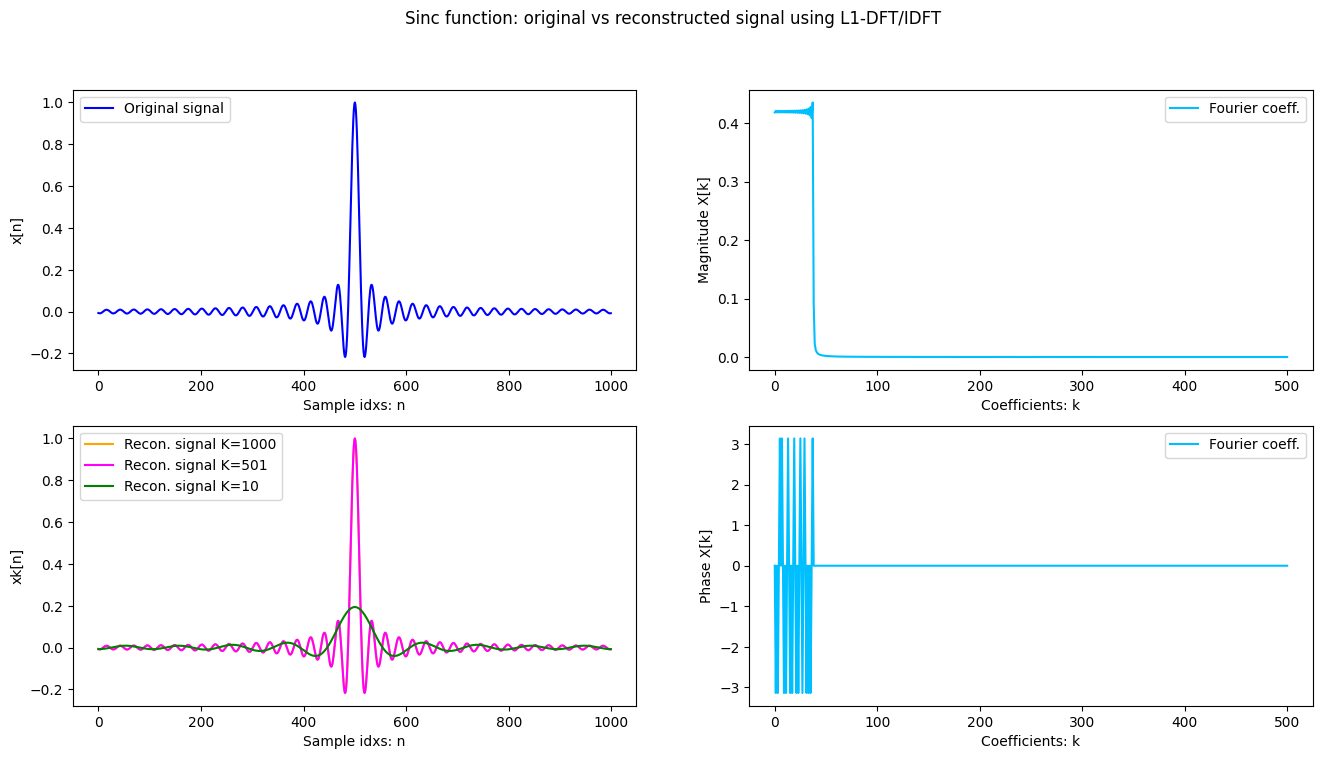

In [4]:
# frequency
f = 12
# number of samples
N = 1000

# original signal
n = np.arange(N)
x = np.sinc(2 * np.pi * f * np.linspace(-0.5, 0.5, N, endpoint=False))

# compute dft and reconstruct the signal
c1 = dft_l1(x, K=1000)
c2 = dft_l1(x, K=501)
c3 = dft_l1(x, K=10)

xk1 = idft_l1(c1, N=N, onlyreal=True)
xk2 = idft_l1(c2, N=N, onlyreal=True)
xk3 = idft_l1(c3, N=N, onlyreal=True)

# plot the results
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Sinc function: original vs reconstructed signal using L1-DFT/IDFT")

axs[0, 0].plot(n, x, c="blue", label="Original signal")
axs[0, 0].set(xlabel="Sample idxs: n", ylabel="x[n]")
axs[0, 0].legend(loc="upper left")

axs[1, 0].plot(n, xk1, c="orange", label="Recon. signal K=1000")
axs[1, 0].plot(n, xk2, c="magenta", label="Recon. signal K=501")
axs[1, 0].plot(n, xk3, c="green", label="Recon. signal K=10")
axs[1, 0].set(xlabel="Sample idxs: n", ylabel="xk[n]")
axs[1, 0].legend(loc="upper left")

axs[0, 1].plot(n[:501], np.abs(c1[:501]), c="deepskyblue", label="Fourier coeff.")
axs[0, 1].set(xlabel="Coefficients: k", ylabel="Magnitude X[k]")
axs[0, 1].legend(loc="upper right")

axs[1, 1].plot(n[:501], np.angle(c1[:501]), c="deepskyblue", label="Fourier coeff.")
axs[1, 1].set(xlabel="Coefficients: k", ylabel="Phase X[k]")
axs[1, 1].legend(loc="upper right")

plt.show()

2025-01-30 20:03:55,830 | INFO | __main__:dft_l1 - Start -> K=10, max_iters=10, eps=1e-06
2025-01-30 20:03:56,343 | INFO | __main__:dft_l1 - End -> iter=10, convergency=0.001, min_abs_loss=0.0001, avg_abs_loss=0.0455, max_abs_loss=0.4927


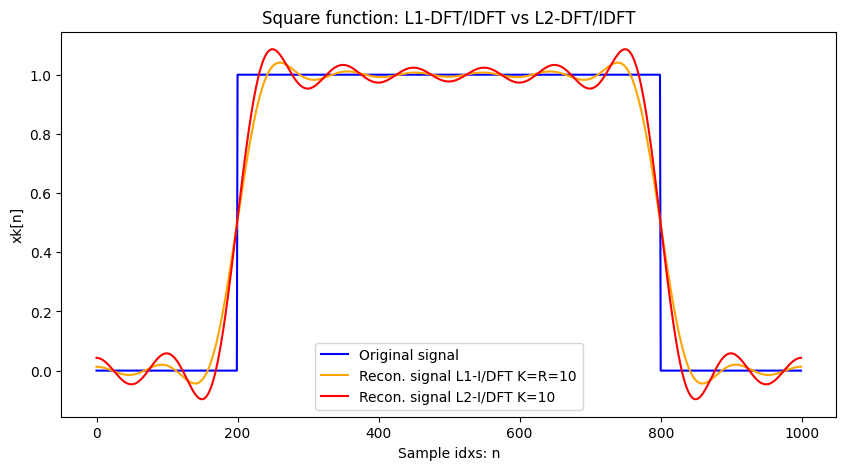

In [5]:
# number of samples
N = 1000

# original signal
n = np.arange(N)
x = np.array([0] * (N//5) + [1] * (3*N//5) + [0] * (N//5))

# compute dft and reconstruct the signal
c1 = dft_l1(x, K=10, max_iters=10)
c2 = np.fft.fft(x) * np.array([1] * (10) + [0] * (N-19) + [1] * (9))

xk1 = idft_l1(c1, N=N, onlyreal=True)
xk2 = np.real(np.fft.ifft(c2))

# plot the results
plt.figure(figsize=(10, 5))
plt.title("Square function: L1-DFT/IDFT vs L2-DFT/IDFT")
plt.plot(n, x, c="blue", label="Original signal")
plt.plot(n, xk1, c="orange", label="Recon. signal L1-I/DFT K=R=10")
plt.plot(n, xk2, c="red", label="Recon. signal L2-I/DFT K=10")
plt.xlabel("Sample idxs: n")
plt.ylabel("xk[n]")
plt.legend(loc="lower center")
plt.show()

## ECG decomposition

In [6]:
# import locale
# def getpreferredencoding(do_setlocale = True):
#    return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding

In [ ]:
# download dataset
!wget -r -N -c -np https://physionet.org/files/ludb/1.0.1/
DATAPATH = "/content/physionet.org/files/ludb/1.0.1/data/"

In [57]:
# @markdown ECG and lead to consider:
id = "154"  # @param {type: "string"}
lead_name = "V3"  # @param ['AVF','AVL','AVR','I','II','III','V1','V2','V3','V4','V5','V6']
# @markdown L1-DFT parameters:
K = 64  # @param {type: "integer"}
max_iters = 50  # @param {type: "integer"}
eps = 1e-5  # @param {type: "number"}
# @markdown Wave detector parameters:
bpm = 80 # @param {type: "integer"}
prob = 0.63  # @param {type: "number"}
fm = 200  # @param {type: "integer"}
to = 200  # @param {type: "integer"}
l = 40  # @param {type: "integer"}
mode = "threshold"  # @param ['threshold', 'rand']
threshold = 0.5  # @param {type: "number"}
# @markdown ---

sigma = GaussianRBF.compute_sigma(prob, ecg.fs // (bpm / 60))
logger.info(f"Gaussian RBF -> ~ 63% prob. at dist=1/sigma={1//sigma}")

# ECG signal
ecg = ECG(DATAPATH, id)
lead = ECG.Lead[lead_name]

n = np.arange(ecg.size)
x = ecg.get_p_signal(lead)

# Fourier coeff. and recon. ECG
c = dft_l1(x, K=K, max_iters=max_iters, eps=eps)
xk = idft_l1(c, N=ecg.size, onlyreal=True)

ders = derivatives(xk)

# predicted markers
pred_markers = detect_waves(
    xk,
    fm=fm,
    to=to,
    l=l,
    rbf=GaussianRBF(sigma=sigma),
    mode=mode,
    threshold=threshold
)

# expected markers
markers = ecg.t_waves(lead)

print(f"Labels ({len(markers)}):")
print(markers)
print(f"Predicted markers ({len(pred_markers)}):")
print(pred_markers)

2025-01-30 21:32:07,765 | INFO | __main__:<cell line: 0> - Gaussian RBF -> ~ 63% prob. at dist=1/sigma=376.0
2025-01-30 21:32:07,837 | INFO | __main__:dft_l1 - Start -> K=64, max_iters=50, eps=1e-05
2025-01-30 21:33:24,433 | INFO | __main__:dft_l1 - End -> iter=38, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.7466, max_abs_loss=145.6256


Labels (8):
[[ 780  850  891]
 [1212 1283 1321]
 [1660 1728 1772]
 [2108 2173 2212]
 [2540 2598 2643]
 [2959 3021 3061]
 [3387 3456 3494]
 [3834 3894 3935]]
Predicted markers (11):
[[ 352  406  458]
 [ 790  844  898]
 [1222 1277 1332]
 [1666 1722 1777]
 [2110 2166 2222]
 [2538 2591 2645]
 [2963 3013 3069]
 [3395 3450 3507]
 [3835 3888 3943]
 [4262 4317 4370]
 [4701 4754 4799]]


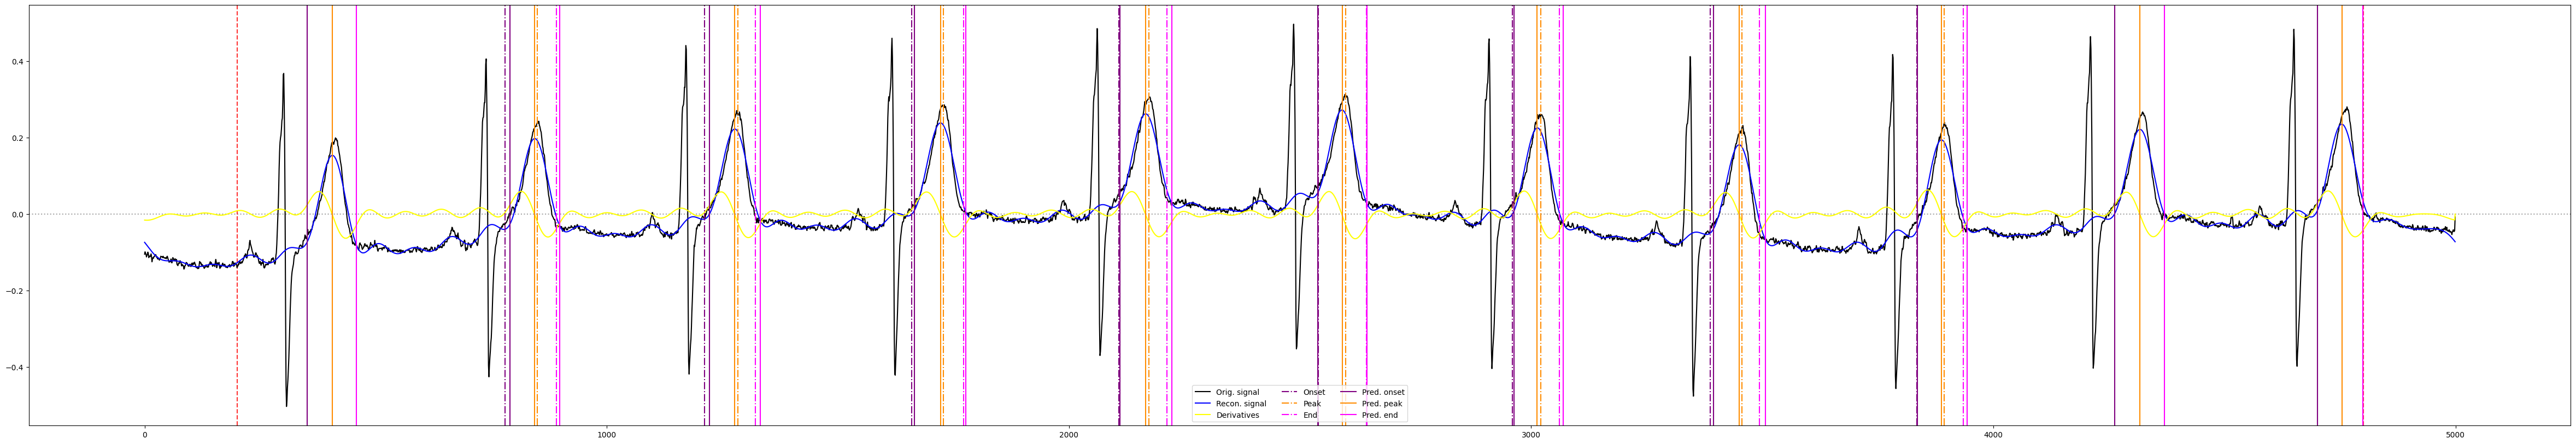

In [58]:
plt.figure(figsize=(60, 10))

plt.axhline(y=0, c="dimgrey", linestyle="dotted", alpha=0.6)
plt.axvline(x=fm, c="red", linestyle="dashed", alpha=0.8)
plt.axvline(x=len(x)-to, c="red", linestyle="dashed", alpha=0.8)

plt.plot(n, x, c="black", label="Orig. signal")
plt.plot(n, xk, c="blue", label="Recon. signal")

plt.plot(n, 10*ders, c="yellow", label="Derivatives")

for i, marker in enumerate(markers):
    plt.axvline(x=marker[0], c="purple", linestyle="dashdot", label="Onset" if i == 0 else "_nolegend_")
    plt.axvline(x=marker[1], c="darkorange", linestyle="dashdot", label="Peak" if i == 0 else "_nolegend_")
    plt.axvline(x=marker[2], c="magenta", linestyle="dashdot", label="End" if i == 0 else "_nolegend_")

for i, pred_marker in enumerate(pred_markers):
    plt.axvline(x=pred_marker[0], c="purple", label="Pred. onset" if i == 0 else "_nolegend_")
    plt.axvline(x=pred_marker[1], c="darkorange", label="Pred. peak" if i == 0 else "_nolegend_")
    plt.axvline(x=pred_marker[2], c="magenta", label="Pred. end" if i == 0 else "_nolegend_")

#plt.xlim(1100, 3100)
plt.legend(loc="lower center", ncol=3)
plt.show()